  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 18.3 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.0/313.0 kB 5.9 MB/s eta 0:00:00
RAM Available: 12.67 GB


Saving 2021-06.laz to 2021-06.laz
Original data size: 1500364 points. Reducing to 75018 points.
Data size after downsampling: 75018 points.
Data size after RANSAC filtering: 71435 points.


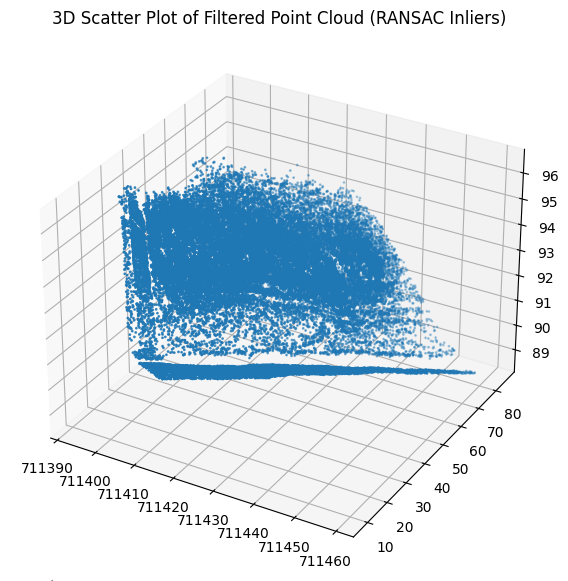

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
# Step 1: Install necessary libraries
!pip install laspy matplotlib numpy giotto-tda scikit-learn
!pip install laspy[laszip]

# Step 2: Import necessary libraries
import laspy
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from sklearn.linear_model import RANSACRegressor
import psutil

# Step 3: Check available RAM
print(f"RAM Available: {psutil.virtual_memory().total / (1024 ** 3):.2f} GB")

# Step 4: Upload and load the LIDAR data
uploaded = files.upload()
file_path = next(iter(uploaded))  # Get file path

# Step 5: Open and read the .laz file
with laspy.open(file_path, laz_backend=laspy.LazBackend.Laszip) as file:
    las = file.read()

# Step 6: Extract x, y, z coordinates from LIDAR data
x = las.x
y = las.y
z = las.z
point_cloud = np.vstack((x, y, z)).T  # Convert the LIDAR data to point cloud format (Nx3 matrix)

# Step 7: Downsample to 10% of the data
data_size = point_cloud.shape[0]
sample_size = int(0.05 * data_size)  # Use 10% of the original data
print(f"Original data size: {data_size} points. Reducing to {sample_size} points.")

# Randomly sample 10% of the point cloud
point_cloud = point_cloud[np.random.choice(data_size, sample_size, replace=False)]

# Step 8: Apply RANSAC to detect and keep points that fit a plane model
print(f"Data size after downsampling: {point_cloud.shape[0]} points.")

# RANSAC model: Fit a plane model (z = ax + by + c)
ransac = RANSACRegressor(residual_threshold=1.0, max_trials=1000)

# Fit RANSAC model to the x, y, z points (z is the target, x and y are the features)
ransac.fit(point_cloud[:, :2], point_cloud[:, 2])

# Get inliers (points that fit the plane model)
inlier_mask = ransac.inlier_mask_
filtered_point_cloud = point_cloud[inlier_mask]

print(f"Data size after RANSAC filtering: {filtered_point_cloud.shape[0]} points.")

# Step 9: Visualize the filtered point cloud to ensure data validity
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_point_cloud[:, 0], filtered_point_cloud[:, 1], filtered_point_cloud[:, 2], s=1)
plt.title('3D Scatter Plot of Filtered Point Cloud (RANSAC Inliers)')
plt.show()

# Step 10: Apply Persistent Homology using Giotto-TDA
# Initialize the Vietoris-Rips persistence object
VR_persistence = VietorisRipsPersistence(
    homology_dimensions=(0, 1),  # We will calculate 0D and 1D homology
    n_jobs=-1,  # Use all available cores for performance
    max_edge_length=150  # Increase max edge length to capture larger scale features
)

# Step 11: Fit and transform the filtered point cloud to get persistence diagrams
diagrams = VR_persistence.fit_transform([filtered_point_cloud])

# Step 12: Print persistence diagrams to understand birth-death range
print("Persistence Diagrams (Birth-Death Pairs):")
for homology_dimension, diagram in enumerate(diagrams):
    print(f"Dimension {homology_dimension}:")
    print(diagram)

# Step 13: Plot the persistence diagrams for 0D and 1D features
if diagrams.size == 0:
    print("No persistence diagram to plot.")
else:
    # Plot the persistence diagram
    plot_diagram(diagrams[0])
    if len(diagrams) > 1:
        plot_diagram(diagrams[1])  # Check 1D features if they exist

    # Customize axis limits for better visibility
    plt.title('Persistence Diagram (0D and 1D Homological Features)')
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.show()

# Step 14: Clean up memory (optional)
del point_cloud, diagrams  # Delete large variables to free up memory
